In [1]:
import torch
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import importlib.util


# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cmap = 'plasma'

In [15]:
def load_files_from_delocalized_folders(base_folder):
    # Dictionaries to hold the loaded data, keyed by delta value.
    actual_fp_y_dict = {}
    norm_fp_y_dict = {}
    eigvals_J_dict = {}

    # Iterate through all entries in the base folder.
    for entry in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, entry)
        # Check that the entry is a directory and follows our naming pattern.
        if os.path.isdir(folder_path) and entry.startswith("random_goe_symmetric_N_100_s_100_mu_0.0_num_delta_1_num_input_100_num_trials_20_b0_1.0_b1_1.0_deltaval_"):
            # Extract the delta value using a regex.
            match = re.match(r"random_goe_symmetric_N_100_s_100_mu_0.0_num_delta_1_num_input_100_num_trials_20_b0_1.0_b1_1.0_deltaval_([\d\.]+)", entry)
            if match:
                delta_str = match.group(1)
                try:
                    delta_val = float(delta_str)
                except ValueError:
                    print(f"Unable to convert '{delta_str}' to float in folder '{entry}'. Skipping.")
                    continue
                print(f"Processing folder '{entry}' with delta value {delta_val}")

                # Build full paths for the expected files.
                actual_fp_y_path = os.path.join(folder_path, "actual_fixed_point_y.pt")
                norm_fp_y_path   = os.path.join(folder_path, "norm_fixed_point_y.pt")
                eigvals_j_path   = os.path.join(folder_path, "eigvals_J.pt")

                # Load the torch object from "actual_fixed_point_y.pt"
                if os.path.isfile(actual_fp_y_path):
                    try:
                        actual_fp_y = torch.load(actual_fp_y_path)
                        actual_fp_y_dict[delta_val] = actual_fp_y
                        print(f"  Loaded '{actual_fp_y_path}'")
                    except Exception as e:
                        print(f"  Error loading '{actual_fp_y_path}': {e}")
                else:
                    print(f"  File not found: '{actual_fp_y_path}'")

                # Load the torch object from "norm_fixed_point_y.pt"
                if os.path.isfile(norm_fp_y_path):
                    try:
                        norm_fp_y = torch.load(norm_fp_y_path)
                        norm_fp_y_dict[delta_val] = norm_fp_y
                        print(f"  Loaded '{norm_fp_y_path}'")
                    except Exception as e:
                        print(f"  Error loading '{norm_fp_y_path}': {e}")
                else:
                    print(f"  File not found: '{norm_fp_y_path}'")

                # Import the module from "eigvals_J.py"
                if os.path.isfile(eigvals_j_path):
                    try:
                        spec = importlib.util.spec_from_file_location("eigvals_J", eigvals_j_path)
                        eigvals_J = importlib.util.module_from_spec(spec)
                        spec.loader.exec_module(eigvals_J)
                        eigvals_J_dict[delta_val] = eigvals_J
                        print(f"  Imported '{eigvals_j_path}'")
                    except Exception as e:
                        print(f"  Error importing '{eigvals_j_path}': {e}")
                else:
                    print(f"  File not found: '{eigvals_j_path}'")
            else:
                print(f"Folder '{entry}' does not match the expected naming pattern.")

    return actual_fp_y_dict, norm_fp_y_dict, eigvals_J_dict

In [16]:
folder_name = '/vast/sr6364/perturbed_organics/data/'
actual_fp_y_dict, norm_fp_y_dict, eigvals_J_dict = load_files_from_delocalized_folders(folder_name)

Processing folder 'random_goe_symmetric_N_100_s_100_mu_0.0_num_delta_1_num_input_100_num_trials_20_b0_1.0_b1_1.0_deltaval_0.0' with delta value 0.0
  Loaded '/vast/sr6364/perturbed_organics/data/random_goe_symmetric_N_100_s_100_mu_0.0_num_delta_1_num_input_100_num_trials_20_b0_1.0_b1_1.0_deltaval_0.0/actual_fixed_point_y.pt'
  Loaded '/vast/sr6364/perturbed_organics/data/random_goe_symmetric_N_100_s_100_mu_0.0_num_delta_1_num_input_100_num_trials_20_b0_1.0_b1_1.0_deltaval_0.0/norm_fixed_point_y.pt'
  Error importing '/vast/sr6364/perturbed_organics/data/random_goe_symmetric_N_100_s_100_mu_0.0_num_delta_1_num_input_100_num_trials_20_b0_1.0_b1_1.0_deltaval_0.0/eigvals_J.pt': 'NoneType' object has no attribute 'loader'
Processing folder 'random_goe_symmetric_N_100_s_100_mu_0.0_num_delta_1_num_input_100_num_trials_20_b0_1.0_b1_1.0_deltaval_0.05' with delta value 0.05
  Loaded '/vast/sr6364/perturbed_organics/data/random_goe_symmetric_N_100_s_100_mu_0.0_num_delta_1_num_input_100_num_trials_

In [17]:
actual_fp_y_dict.keys()
param_file_path = os.path.join('/vast/sr6364/perturbed_organics/data/random_goe_symmetric_N_100_s_100_mu_0.0_num_delta_1_num_input_100_num_trials_20_b0_1.0_b1_1.0_deltaval_0.0', 'parameters.json')
with open(param_file_path, 'r') as f:
    params = json.load(f)
input_range = np.array(params['input_range'])

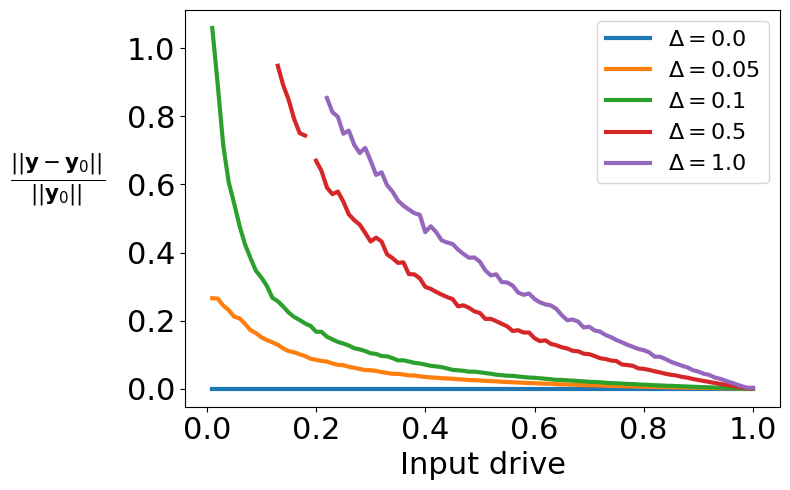

In [18]:
plt.figure(figsize=(8, 5))
for delta_val, actual_fp_y in actual_fp_y_dict.items():
    norm_fixed_point_y = norm_fp_y_dict[delta_val]
    y_ratio = torch.norm(norm_fixed_point_y - actual_fp_y, dim=3) / torch.norm(norm_fixed_point_y, dim=3)
    y_ratio_mean = y_ratio.mean(dim=2)
    plt.plot(input_range, y_ratio_mean[0, :], label=f"$\Delta = {delta_val}$", linewidth=3)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$\frac{||\mathbf{y}-\mathbf{y}_0||}{||\mathbf{y}_0||}$", fontsize=22, rotation=0, labelpad=50)
plt.legend(fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

In [22]:
y_ratio_mean.shape

torch.Size([1, 100])